In [260]:
from __future__ import print_function
import numpy as np
import astropy.units as u
import astropy.constants as consts
import matplotlib.pyplot as plt
import OpenGoddard.optimize as og
import poliastro as pa
import math
import poliastro.bodies as paBody

In [261]:
u.year

Unit("yr")

In [262]:
2*(paBody.Sun.mass).unit

<Quantity 2. kg>

In [263]:
class System():
    def __init__(self, attractor=paBody.Sun, lref = 1*u.AU, mref = 1*u.kg):
        
        #define constants
        self.attractor = attractor
        self.mu = consts.G*attractor.mass
        
        #define non-dimensionalization parameters
        self.lref = lref.si;
        self.mref = mref.si;
        self.vref = (np.sqrt(self.mu/self.lref)).si #v of orbit around the attractor at lref distance
        self.tref = (self.lref/self.vref).si #note, this is not one year
        self.aref = ((self.vref)**2/self.lref).si
        self.thref = 1*u.rad; #angular reference
        self.omref = (self.thref/self.tref).si; #angular velocity unit (om for omega)
    
    def gravity(self,pos, dimensional=True):
        """
        Returns the gravitational acceleration at a given point, in polar coordinates. 
        Currently assumes there is only one attracting body.
        
        Arg:
            Pos: [r, theta] is the position from the main attractor
            Dimensional: If true, returns astropy quantities, else returns non-dimensionalized python scalars.
            
        Returns: (a_r, a_theta) which is the radial and tangential gravitational acceleration vector. 
        
        """
        
        if dimensional== True:
            a_r = -(self.mu/(pos[0]**2)).si
            a_t = 0*(a_r.unit) #ensure they are of the same units
        else:
            a_r = -(1/(pos[0]**2))
            a_t = 0 #ensure they are of the same units
        
        return (a_r, a_t)
        
    def __str__(self):
        return 'System with attractor: {}'.format(self.attractor)

In [264]:
sys = System()

In [265]:
sys.gravity((5,0),dimensional=False)

(-0.04, 0)

In [266]:
(3.5*u.year/sys.tref)

<Quantity 6.96844292e-07 yr / s>

In [267]:
float(3.5*u.year/sys.tref)

21.990733415635905

In [268]:
sys.mu


<Quantity 1.32712442e+20 m3 / s2>

In [269]:
(90*u.deg/(math.pi*u.rad)).si

<Quantity 0.5>

In [306]:
class Mission():
    
    def __init__(self, system):
        """
        Initializes the Mission.
        
        Args:
            system (electricTortoise/System)
        
        """
        #Requires the system to be set up first. 
        #Calls on the system properties.
        
        self.sys = system
        
    def spacecraft_properties(self, c = 3000*u.m/u.s):
        """ 
        Function defines the key parameters of the spacecraft
        
        Args: 
            c (Astropy/Quantity): Engine exhaust speed (for example in m/s)
        """
        
        self.c = c
        self.nd_c = float(self.c/self.sys.vref)
        
        
    #set up the problem
    def define_problem_single_phase(self, num_nodes = 20, max_iterations = 5):
        
        """
        Defines the openGoddard problem statement, assuming the entire problem is to be solved in a single phase. 
        
        Args:
            num_nodes (int): Number of computation points in time axis.
            max_iterations (int):  Maximum number of iterations.
            
            Hint. 
            More nodes allow for higher degree approximations of the solution
            More iterations allow for finer tuning of the solution towards optimal. 
            
        Returns:
            None.
        """
        
        #Define time bounds
        time_init = [0.0, self.nd_T_max]
        
        n = [num_nodes]
        max_iterations = max_iterations
        
        #hard coded the number of states
        num_states = [5]
        num_controls = [2]
        
        #define problem
        self.problem = og.Problem(time_init, n, num_states, num_controls, max_iterations)
        
        #create time vector
        self.nd_time = self.problem.time_all_section
        self.time = self.nd_time*self.sys.tref
        return
    
    def get_states(self):
        """ Function returns tuple of state arrays"""
        m  = self.problem.states_all_section(0)
        r  = self.problem.states_all_section(1)
        th = self.problem.states_all_section(2)
        vr = self.problem.states_all_section(3)
        vt = self.problem.states_all_section(4)
        
        return (m,r,th,vr,vt)
    
    def get_controls(self):
        """ Function returns tuple of control arrays"""
        Tr = self.problem.controls_all_section(0)
        Tt = self.problem.controls_all_section(1)
        
        return (Tr, Tt)
    
    
    def dynamics(self, prob, obj, section):
        
        #states must be dimensionless here. Or at least in a consistent set of units.
        
        states = self.get_states()
        controls = self.get_controls()
        
        #determine rate of change of state
        changes = self.spacecraft_dynamics(states,controls,dimensionless=True,simple_gravity=True)
        
        print(len(changes))
        
        #store into dynamics object
        dx = og.Dynamics(prob, section)
        for i in range(len(changes)):
            dx[i] = changes[i]
            
        return dx()
    
        
    def set_max_final_time(self, T_max = 3*u.year):
        """
        Sets the maximum final time of the mission (both dimensional and non-dimensional). 
        
        Args:
            T_max (Astropy/Quantity): Final time for mission.

        Returns:
            None.
        """
        
        self.T_max = T_max
        
        #set the non-dimensionalized float
        self.nd_T_max = float(T_max/self.sys.tref)
        
        return
    
    def set_full_initial_state(self, initial_state):
        """
        Sets the initial state of the problem fully.
        Using this function explicity sets the starting state.
        
        Args:
            initial_state (5x1 array of Astropy/Quantities): State vector. 
            
            State Vector = (Mass, Radial Position, Angular Position, Radial Velocity, Tangential Velocity)
            
        Retuns:
            None.
        """
        self.desired_initial_state = initial_state
            
        self.m0  = initial_state[0]
        self.r0  = initial_state[1]
        self.th0 = initial_state[2]
        self.vr0 = initial_state[3]
        self.vt0 = initial_state[4]
        
        #save non-dimensional versions
        self.nd_m0  = float(self.m0 /self.sys.mref);
        self.nd_r0  = float(self.r0 /self.sys.lref);
        self.nd_th0 = float(self.th0/self.sys.thref)
        self.nd_vr0 = float(self.vr0/self.sys.vref)
        self.nd_vt0 = float(self.vt0/self.sys.vref)
        
        return
    
    def set_full_final_state(self, final_state):
        """
        Sets the final state of the problem fully.
        Using this function explicity sets the ending state.
        
        Args:
            final_state (5x1 array of Astropy/Quantities): State vector. 
            
            State Vector = (Mass, Radial Position, Angular Position, Radial Velocity, Tangential Velocity)
            
        Retuns:
            None.
        """
        
        self.desired_final_state = final_state
        
        self.mf  = final_state[0]
        self.rf  = final_state[1]
        self.thf = final_state[2]
        self.vrf = final_state[3]
        self.vtf = final_state[4]
        
        #save non-dimensional versions
        self.nd_mf  = float(self.mf /self.sys.mref);
        self.nd_rf  = float(self.rf /self.sys.lref);
        self.nd_thf = float(self.thf/self.sys.thref)
        self.nd_vrf = float(self.vrf/self.sys.vref)
        self.nd_vtf = float(self.vtf/self.sys.vref)
        
        return
    
    def get_time_vector(self,dimensionless=False):
        """Getter for time vector. 
        
        Args:
            dimensionless (boolean): If True, returns float array of times. If False, returns time array as Astropy/Quantity
            
        Returns:
            Time vector.
        """
        #get updated time from the problem.
        self.nd_time = self.problem.time_update()
        self.time = self.nd_time*self.sys.tref;
        
        if dimensionless == True:
            return self.nd_time
        else:
            return self.time
    
    def spacecraft_dynamics(self, state, controls = None, dimensionless = True,simple_gravity = True):
        """
            Function returns the rate of change of the state of the spacecraft. 
        """
        m  = state[0]
        r  = state[1]
        th = state[2]
        vr = state[3]
        vt = state[4]
        
        if controls is not None:
            Tr = controls[0]
            Tt = controls[1]
        else:
            Tr = np.zeros_like(m)
            Tt = np.zeros_like(m)
            
        
        T_mag = np.sqrt(Tr**2+Tt**2)
        
        if dimensionless == True:
            mdot = -T_mag/self.nd_c
            rdot = vr
            thdot = vt/r
            vrdot = vt**2 / r - 1 / r**2 + Tr/m
            vtdot = - vr * vt / r + Tt/m
        
        if dimensionless == False:
            mdot = -T_mag/self.c
            rdot = vr
            thdot = vt/r
            vrdot = vt**2 / r - self.sys.mu / r**2 + Tr/m
            vtdot = - vr * vt / r + Tt/m
            
        return (mdot,rdot,thdot,vrdot,vtdot)
    
        
    

In [307]:
mission=Mission(sys)
mission.set_max_final_time(7*u.year)
mission.spacecraft_properties(c = 3000*u.m/u.s)
mission.set_full_initial_state([2000*u.kg, 1*u.AU, 0*u.rad, 0*u.m/u.s, 0*u.m/u.s])
mission.set_full_final_state([1000*u.kg, 2*u.AU, 0*u.rad, 0*u.m/u.s, 0*u.m/u.s])

In [308]:
mission.nd_T_max

43.98146683127181

In [309]:
print(mission.desired_initial_state)
print(mission.desired_final_state)

[<Quantity 2000. kg>, <Quantity 1. AU>, <Quantity 0. rad>, <Quantity 0. m / s>, <Quantity 0. m / s>]
[<Quantity 1000. kg>, <Quantity 2. AU>, <Quantity 0. rad>, <Quantity 0. m / s>, <Quantity 0. m / s>]


In [310]:
mission.define_problem_single_phase()

In [311]:
mission.time.to(u.year)

<Quantity [0.        , 0.06739703, 0.22422925, 0.46592708, 0.78621109,
           1.17678259, 1.62752498, 2.12676386, 2.66156903, 3.21808922,
           3.78191078, 4.33843097, 4.87323614, 5.37247502, 5.82321741,
           6.21378891, 6.53407292, 6.77577075, 6.93260297, 7.        ] yr>

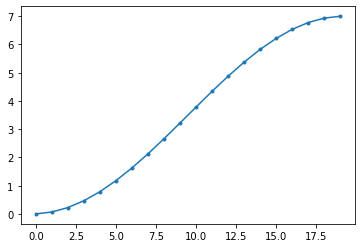

In [312]:
plt.plot(mission.get_time_vector(dimensionless=False).to(u.year),'.-')

In [314]:
mission.dynamics(mission.problem,mission,0)

5


/Users/Devansh/Documents/GitHub/electricTortoise/mypython/lib/python3.6/site-packages/ipykernel_launcher.py:222: RuntimeWarning: invalid value encountered in true_divide
/Users/Devansh/Documents/GitHub/electricTortoise/mypython/lib/python3.6/site-packages/ipykernel_launcher.py:223: RuntimeWarning: invalid value encountered in true_divide
/Users/Devansh/Documents/GitHub/electricTortoise/mypython/lib/python3.6/site-packages/ipykernel_launcher.py:223: RuntimeWarning: divide by zero encountered in true_divide
/Users/Devansh/Documents/GitHub/electricTortoise/mypython/lib/python3.6/site-packages/ipykernel_launcher.py:224: RuntimeWarning: invalid value encountered in true_divide


array([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan])